
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/books/functional_imaging/AFNI_preprocessing_and_glm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/>   </a>

# AFNI Preprocessing and GLM

Author: Monika Doerig

Citation:

__Andy's Brain Book__:

- This AFNI example is based on the [AFNI Tutorial: Statistics and Modeling](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_05_1stLevelAnalysis.html)  from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

__Data from OpenNeuro:__ Flanker Dataset
- Kelly AMC and Uddin LQ and Biswal BB and Castellanos FX and Milham MP (2018). Flanker task (event-related). [OpenNeuro Dataset ds000102](https://openneuro.org/datasets/ds000102/versions/00001/). [Dataset] doi: null
- Kelly AM, Uddin LQ, Biswal BB, Castellanos FX, Milham MP. Competition between functional brain networks mediates behavioral variability. Neuroimage. 2008 Jan 1;39(1):527-37. doi: [10.1016/j.neuroimage.2007.08.008](https://doi.org/10.1016/j.neuroimage.2007.08.008). Epub 2007 Aug 23. PMID: 17919929.
- Mennes, M., Kelly, C., Zuo, X.N., Di Martino, A., Biswal, B.B., Castellanos, F.X., Milham, M.P. (2010). Inter-individual differences in resting-state functional connectivity predict task-induced BOLD activity. Neuroimage, 50(4):1690-701. doi: [10.1016/j.neuroimage.2010.01.002](https://doi.org/10.1016/j.neuroimage.2010.01.002). Epub 2010 Jan 15. Erratum in: Neuroimage. 2011 Mar 1;55(1):434
- Mennes, M., Zuo, X.N., Kelly, C., Di Martino, A., Zang, Y.F., Biswal, B., Castellanos, F.X., Milham, M.P. (2011). Linking inter-individual differences in neural activation and behavior to intrinsic brain dynamics. Neuroimage, 54(4):2950-9. doi: [10.1016/j.neuroimage.2010.10.046](https://doi.org/10.1016/j.neuroimage.2010.10.046)


## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


### Load AFNI

In [3]:
import lmod
await lmod.load('afni/21.2.00')
await lmod.list()

['afni/21.2.00']

### Install tcsh

In [4]:
%%capture
!sudo apt update; sudo apt install tcsh

Check the installation:

In [5]:
%%script tcsh
set var = "hello from tcsh"
echo $var

hello from tcsh


### Import Python Modules

In [6]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Image
from nilearn import plotting
from scipy.stats import t

## Data download

In [7]:
PATTERN = "sub-08"
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get $PATTERN

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/27.0 [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/23.0 [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/2.15k [00:00<?, ? Objects/s]
                                                                                
Resolving:   0%|                                | 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] scanning for unlocked files (this may take some time)                 
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore 
[INFO   ] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/

The data is structured in BIDS format:

In [8]:
!tree -L 4 ds000102

ds000102
├── CHANGES
├── README
├── T1w.json
├── dataset_description.json
├── derivatives
│   └── mriqc
│       ├── aMRIQC.csv -> ../../.git/annex/objects/Q4/jv/MD5E-s14180--3addf0456b803b7c5ec5147481ecdd62.csv/MD5E-s14180--3addf0456b803b7c5ec5147481ecdd62.csv
│       ├── anatomical_group.pdf -> ../../.git/annex/objects/6m/q9/MD5E-s98927--d11151f65ae061833e7fd4373adfec3f.pdf/MD5E-s98927--d11151f65ae061833e7fd4373adfec3f.pdf
│       ├── anatomical_sub-01.pdf -> ../../.git/annex/objects/K3/7x/MD5E-s2747349--5d40f2a54fb4194ac4a79f0295ff51c0.pdf/MD5E-s2747349--5d40f2a54fb4194ac4a79f0295ff51c0.pdf
│       ├── anatomical_sub-02.pdf -> ../../.git/annex/objects/Kx/Kv/MD5E-s2803965--56f6b768362bd9b7f0ef501b8cb6dde6.pdf/MD5E-s2803965--56f6b768362bd9b7f0ef501b8cb6dde6.pdf
│       ├── anatomical_sub-03.pdf -> ../../.git/annex/objects/kx/g5/MD5E-s2809843--e90d7a4859ed4be986b55e23f93ca89d.pdf/MD5E-s2809843--e90d7a4859ed4be986b55e23f93ca89d.pdf
│       ├── anatomical_sub-04.pdf -> ../../.git/annex/ob

## Create timing files
To model brain activity during different conditions of the Flanker task, we first need to create timing files based on the experimental events. These files capture when each trial occurred, how long it lasted, and whether any parametric modulation should be applied. This information is stored in each subject's events.tsv file. We will extract the relevant details - condition name, onset, and duration - and convert them into AFNI’s timing file format. For each condition (congruent and incongruent), we will generate timing files for both runs, then combine them into condition-specific .1D files. These timing files will later be used in the GLM (general linear model) to estimate brain responses to each condition.

To automate this process, we will download a Bash script called make_Timings.sh from Andy’s [AFNI_Scripts repository](https://github.com/andrewjahn/AFNI_Scripts/blob/master/make_Timings.sh). This script should be placed in the experimental folder containing the subject directories (in our case, the ds000102/ folder). 

In [9]:
!wget -O ds000102/make_Timings.sh https://raw.githubusercontent.com/andrewjahn/AFNI_Scripts/master/make_Timings.sh

--2025-05-01 05:26:07--  https://raw.githubusercontent.com/andrewjahn/AFNI_Scripts/master/make_Timings.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 953 [text/plain]
Saving to: ‘ds000102/make_Timings.sh’

ds000102/make_Timin 100%[===================>]     953  --.-KB/s    in 0s      

2025-05-01 05:26:07 (70.9 MB/s) - ‘ds000102/make_Timings.sh’ saved [953/953]



####
Once the script is downloaded into the ```ds000102/``` folder, we can execute it directly from the notebook. The command below does three things:

1. ```cd ds000102``` changes into the experimental directory that contains the subject folders.

2. ```chmod +x make_Timings.sh``` makes the script executable.

3. ```bash make_Timings.sh``` runs the script.

After running this command, you should see new timing files (e.g., ```congruent.1D```, ```incongruent.1D```) inside each subject’s func/ directory. These files are now ready to be used in the first-level GLM analysis.

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
        You may see a SyntaxWarning from AFNI’s internal Python scripts when running this command — this can be safely ignored and does not affect the output.
    </p>
</div>

In [10]:
!cd ds000102 && chmod +x make_Timings.sh && bash make_Timings.sh

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you miss

Check the output:

In [11]:
!cat ds000102/sub-08/func/incongruent.1D

0 10 20 52 88 130 144 174 248 260 274 
0 10 52 64 88 150 164 174 196 232 260 


## Running Preprocessing and First Level Analysis for sub-08

All of the preprocessing steps (from setup through scaling) for subject ```sub-08``` were introduced and explained in the example notebook about *Preprocessing with AFNI*- which is highly inspired by [Andy's Brain Book’s excellent AFNI tutorial](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_04_Preprocessing.html).
There, it is covered how to use ```afni_proc.py``` to generate an automated pipeline, and how to interpret each preprocessing block. In this section, we extend that workflow by adding a ```regress``` block to model task-related brain activity using a general linear model (GLM):

<div style="background-color: #e8f5e9; padding: 12px; border-left: 6px solid #66bb6a; margin: 10px 0; font-size: 14px;">
<b>Preprocessing and GLM Workflow:</b><br><br>
➡️ <code>setup</code> ➡️ <code>tcat</code>  ➡️ <code>align</code> ➡️ <code>tlrc</code> ➡️ <code>volreg</code> ➡️ <code>blur</code> ➡️ <code>mask</code> ➡️ <code>scale</code> ➡️ <code>regress</code> 🧠<br><br>
    
✅ <b>outputs:</b> includes fitted time series, beta weights, and statistical maps from the GLM.<br>
    
🧾 <b>regress step:</b> Incorporates timing files, HRF modeling (<code>GAM</code>), symbolic GLTs, and executes <code>3dREMLfit</code> for improved autocorrelation modeling.
</div>

In [12]:
!afni_proc.py                                                                                               \
    -subj_id                     sub_08                                                                    \
    -script                      proc.sub_08                                                               \
    -scr_overwrite                                                                                         \
    -out_dir                     ./afni_pro_glm/sub_08.results                                             \
    -blocks                      align tlrc volreg blur mask scale regress                                 \
    -copy_anat                   ./ds000102/sub-08/anat/sub-08_T1w.nii.gz                                  \
    -dsets                                                                                                 \
                                 ./ds000102/sub-08/func/sub-08_task-flanker_run-1_bold.nii.gz              \
                                 ./ds000102/sub-08/func/sub-08_task-flanker_run-2_bold.nii.gz              \
    -tcat_remove_first_trs       0                                                                         \
    -align_opts_aea              -giant_move                                                               \
    -tlrc_base                   MNI_avg152T1+tlrc                                                         \
    -volreg_align_to             MIN_OUTLIER                                                               \
    -volreg_align_e2a                                                                                      \
    -volreg_tlrc_warp                                                                                      \
    -blur_size                   4.0                                                                       \
    -regress_stim_times          ./ds000102/sub-08/func/congruent.1D ./ds000102/sub-08/func/incongruent.1D \
    -regress_stim_labels         congruent incongruent                                                     \
    -regress_stim_types          times times                                                               \
    -regress_basis               GAM                                                                       \
    -regress_opts_3dD                                                                                      \
        -gltsym 'SYM: +incongruent -congruent' -glt_label 1 incongruent-congruent                          \
        -gltsym 'SYM: +congruent -incongruent' -glt_label 2 congruent-incongruent                          \
        -jobs 8                                                                                            \
        -GOFORIT 0                                                                                         \
    -regress_no_motion_deriv                                                                               \
    -regress_run_clustsim         no                                                                       \
    -regress_reml_exec                                                                                     \
    -html_review_style        pythonic

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-08_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
-- no 3dClustSim (since no blur estimation)
** failed to load module matplotlib.pyplot
** warning: -html_review_style pythonic: missing matplotlib library
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: proc.sub_08

    to execute via tcsh:
         tcsh -xef proc.sub_08 |& tee output.proc.sub_08

    to execute via bash:
         

<div style="background-color: #fff9db; padding: 5px; border-radius: 5px; font-family: monospace; color: #333;">
<pre style="margin: 0; background-color: #fff9db;">

Below is a brief explanation of the key options added to ```afni_proc.py```:

```-blocks ... regress```: Adds the GLM regression step to the processing pipeline, so we can estimate condition-specific brain activity.

```-regress_stim_times```: Points to the timing .1D files (e.g., congruent.1D, incongruent.1D) we created earlier. These specify when each condition occurred during the experiment.

```-regress_stim_labels```: Assigns labels to the timing files. These labels are used internally in AFNI (and in our symbolic GLTs) to refer to each condition.

```-regress_basis GAM```: Applies the canonical hemodynamic response function (HRF) using a Gamma function, which models the typical shape of neural activation over time in response to a stimulus.

```-regress_stim_types```: *times* - indicates that the stimulus timing files list event onsets in seconds.

```-regress_opts_3dD```: Passes additional options to the 3dDeconvolve command that runs the regression. In this case:

```-gltsym 'SYM: +incongruent -congruent'```: Defines a contrast comparing incongruent > congruent.

```-gltsym 'SYM: +congruent -incongruent'```: Defines the reverse contrast, congruent > incongruent.

```-glt_label```: Assigns human-readable labels to each contrast.

```-jobs 8```: Specifies using 8 CPU threads for faster computation.

```-GOFORIT 0```: Prevents the script from overriding collinearity warnings in the design matrix. Useful for debugging.

```-regress_no_motion_deriv```: Omits the temporal derivatives of the motion parameters from the regression model. These derivatives can help account for rapid or complex head motion, but may be unnecessary if the data is relatively clean or if simpler motion correction is sufficient.

```-regress_run_clustsim no```: Disables real-time cluster-level threshold simulations, since we’re not doing single-subject inference.

```-regress_reml_exec```: Tells AFNI to run 3dREMLfit, which uses a more sophisticated model of temporal autocorrelation. This is typically more accurate than the default 3dDeconvolve and recommended for group-level analysis later.

```-html_review_style pythonic```: Generates a user-friendly HTML summary of the analysis, styled with Python tools.
</pre>
</div>

**Correcting the Script**

Before running the preprocessing script, we need to make a small manual adjustment. AFNI's ```@auto_tlrc``` command, which handles nonlinear alignment to template space, sometimes fails if the anatomical image is far from the template origin. To prevent this, we insert the ```-init_xform AUTO_CENTER``` option into the generated script. This centers the anatomical image before alignment, helping ensure the normalization step runs smoothly. The following code snippet does this automatically by editing the ```proc.sub_08``` script before execution. This step was also discussed in more detail in the Neurodesk example notebook *AFNI Preprocessing*.

In [13]:
# Edit proc.sub_08
with open('./proc.sub_08', 'r') as file:
    lines = file.readlines()

# Insert "-init_xform AUTO_CENTER" into the @auto_tlrc command
for idx, line in enumerate(lines):
    if line.strip().startswith('@auto_tlrc'):
        lines[idx] = line.strip() + ' -init_xform AUTO_CENTER\n'

# Save it back
with open('proc.sub_08', 'w') as file:
    file.writelines(lines)

**Running the Preprocessing and GLM Script**

With the script ```proc.sub_08``` prepared, we're ready to run it. This will carry out all preprocessing steps followed by the GLM analysis and and logs the full output to ```output.proc.sub_08```, allowing to review everything that happened during processing:

In [14]:
! tcsh -xef proc.sub_08 |& tee output.proc.sub_08

echo auto-generated by afni_proc.py, Thu May  1 05:26:23 2025
auto-generated by afni_proc.py, Thu May  1 05:26:23 2025
echo (version 7.16, May 19, 2021)
(version 7.16, May 19, 2021)
echo execution started: `date`
date
execution started: Thu May  1 05:26:24 UTC 2025
afni -ver
Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 'Nerva')
afni_history -check_date 27 Jun 2019
-- is current: afni_history as new as: 27 Jun 2019
               most recent entry is:   30 Jun 2021
if ( 0 ) then
if ( 0 > 0 ) then
set subj = sub_08
endif
set output_dir = ./afni_pro_glm/sub_08.results
if ( -d ./afni_pro_glm/sub_08.results ) then
set runs = ( `count -digits 2 1 2` )
count -digits 2 1 2
mkdir -p ./afni_pro_glm/sub_08.results
mkdir ./afni_pro_glm/sub_08.results/stimuli
cp ./ds000102/sub-08/func/congruent.1D ./ds000102/sub-08/func/incongruent.1D ./afni_pro_glm/sub_08.results/stimuli
3dcopy ds000102/sub-08/anat/sub-08_T1w.nii.gz ./afni_pro_glm/sub_08.results/sub-08_T1w
++ 3dcopy: AFNI 

## Results: Examining the output
Let's take a look at the results directory. Files containing the ```"pb"``` string are the preprocessed functional images at each step of the pipeline, while those with ```"T1w"``` refer to the preprocessed anatomical images. Additional auxiliary functional images are generated to assist with specific preprocessing steps, and auxiliary text files store information such as transformation matrices and motion parameters.

The file named ```stats.sub_08+tlrc``` contains results from the traditional ```3dDeconvolve``` analysis, whereas ```stats.sub_08_REML+tlrc``` contains results from the ```3dREMLfit``` approach, which accounts for temporal autocorrelation.

You'll also see several files beginning with ```"X"```, such as ```X.xmat.1D```, which represent components of the design matrix used in the regression analysis.

AFNI also automatically creates a quality control directory named ```QC_sub_08```.

In [15]:
!ls ./afni_pro_glm/sub_08.results

3dREMLfit.err				 out.gcor.1D
@epi_review.sub_08			 out.mask_ae_dice.txt
@ss_review_basic			 out.mask_ae_overlap.txt
@ss_review_driver			 out.mask_at_dice.txt
@ss_review_driver_commands		 out.min_outlier.txt
@ss_review_html				 out.pre_ss_warn.txt
QC_sub_08				 out.review_html
TSNR.sub_08+tlrc.BRIK			 out.ss_review.sub_08.txt
TSNR.sub_08+tlrc.HEAD			 out.ss_review_uvars.json
X.jpg					 outcount.r01.1D
X.stim.xmat.1D				 outcount.r02.1D
X.xmat.1D				 outcount_rall.1D
_tmp.txt				 pb00.sub_08.r01.tcat+orig.BRIK
_tmp2.txt				 pb00.sub_08.r01.tcat+orig.HEAD
all_runs.sub_08+tlrc.BRIK		 pb00.sub_08.r02.tcat+orig.BRIK
all_runs.sub_08+tlrc.HEAD		 pb00.sub_08.r02.tcat+orig.HEAD
anat_final.sub_08+tlrc.BRIK		 pb01.sub_08.r01.volreg+tlrc.BRIK
anat_final.sub_08+tlrc.HEAD		 pb01.sub_08.r01.volreg+tlrc.HEAD
anat_w_skull_warped+tlrc.BRIK		 pb01.sub_08.r02.volreg+tlrc.BRIK
anat_w_skull_warped+tlrc.HEAD		 pb01.sub_08.r02.volreg+tlrc.HEAD
corr_brain+tlrc.BRIK			 pb02.sub_08.r01.blur+tlrc.BRIK
corr_brain+

### Design Matrix
Let's visualize the graphical representation of the design matrix to check the experimental design setup. The image shows how each condition (stimulus) is modeled across the time series. The ```"X"``` files contain important information about how the stimuli, motion parameters, and other regressors are combined into the matrix for the GLM analysis.

In this case, the design matrix includes the following regressors in order:

- The first 6 regressors (```Run#1Pol#0``` to ```Run#2Pol#2```) are drift (polynomial) terms used to model low-frequency signal fluctuations separately for each run.

- The next 2 regressors (```congruent#0``` and ```incongruent#0```) correspond to the task-related conditions and model stimulus events across both runs.

- The final 6 regressors (```mot_demean[0]#0``` to ```mot_demean[5]#0```) represent motion parameters for the entire session, capturing estimated head movement in 3 translational and 3 rotational directions.

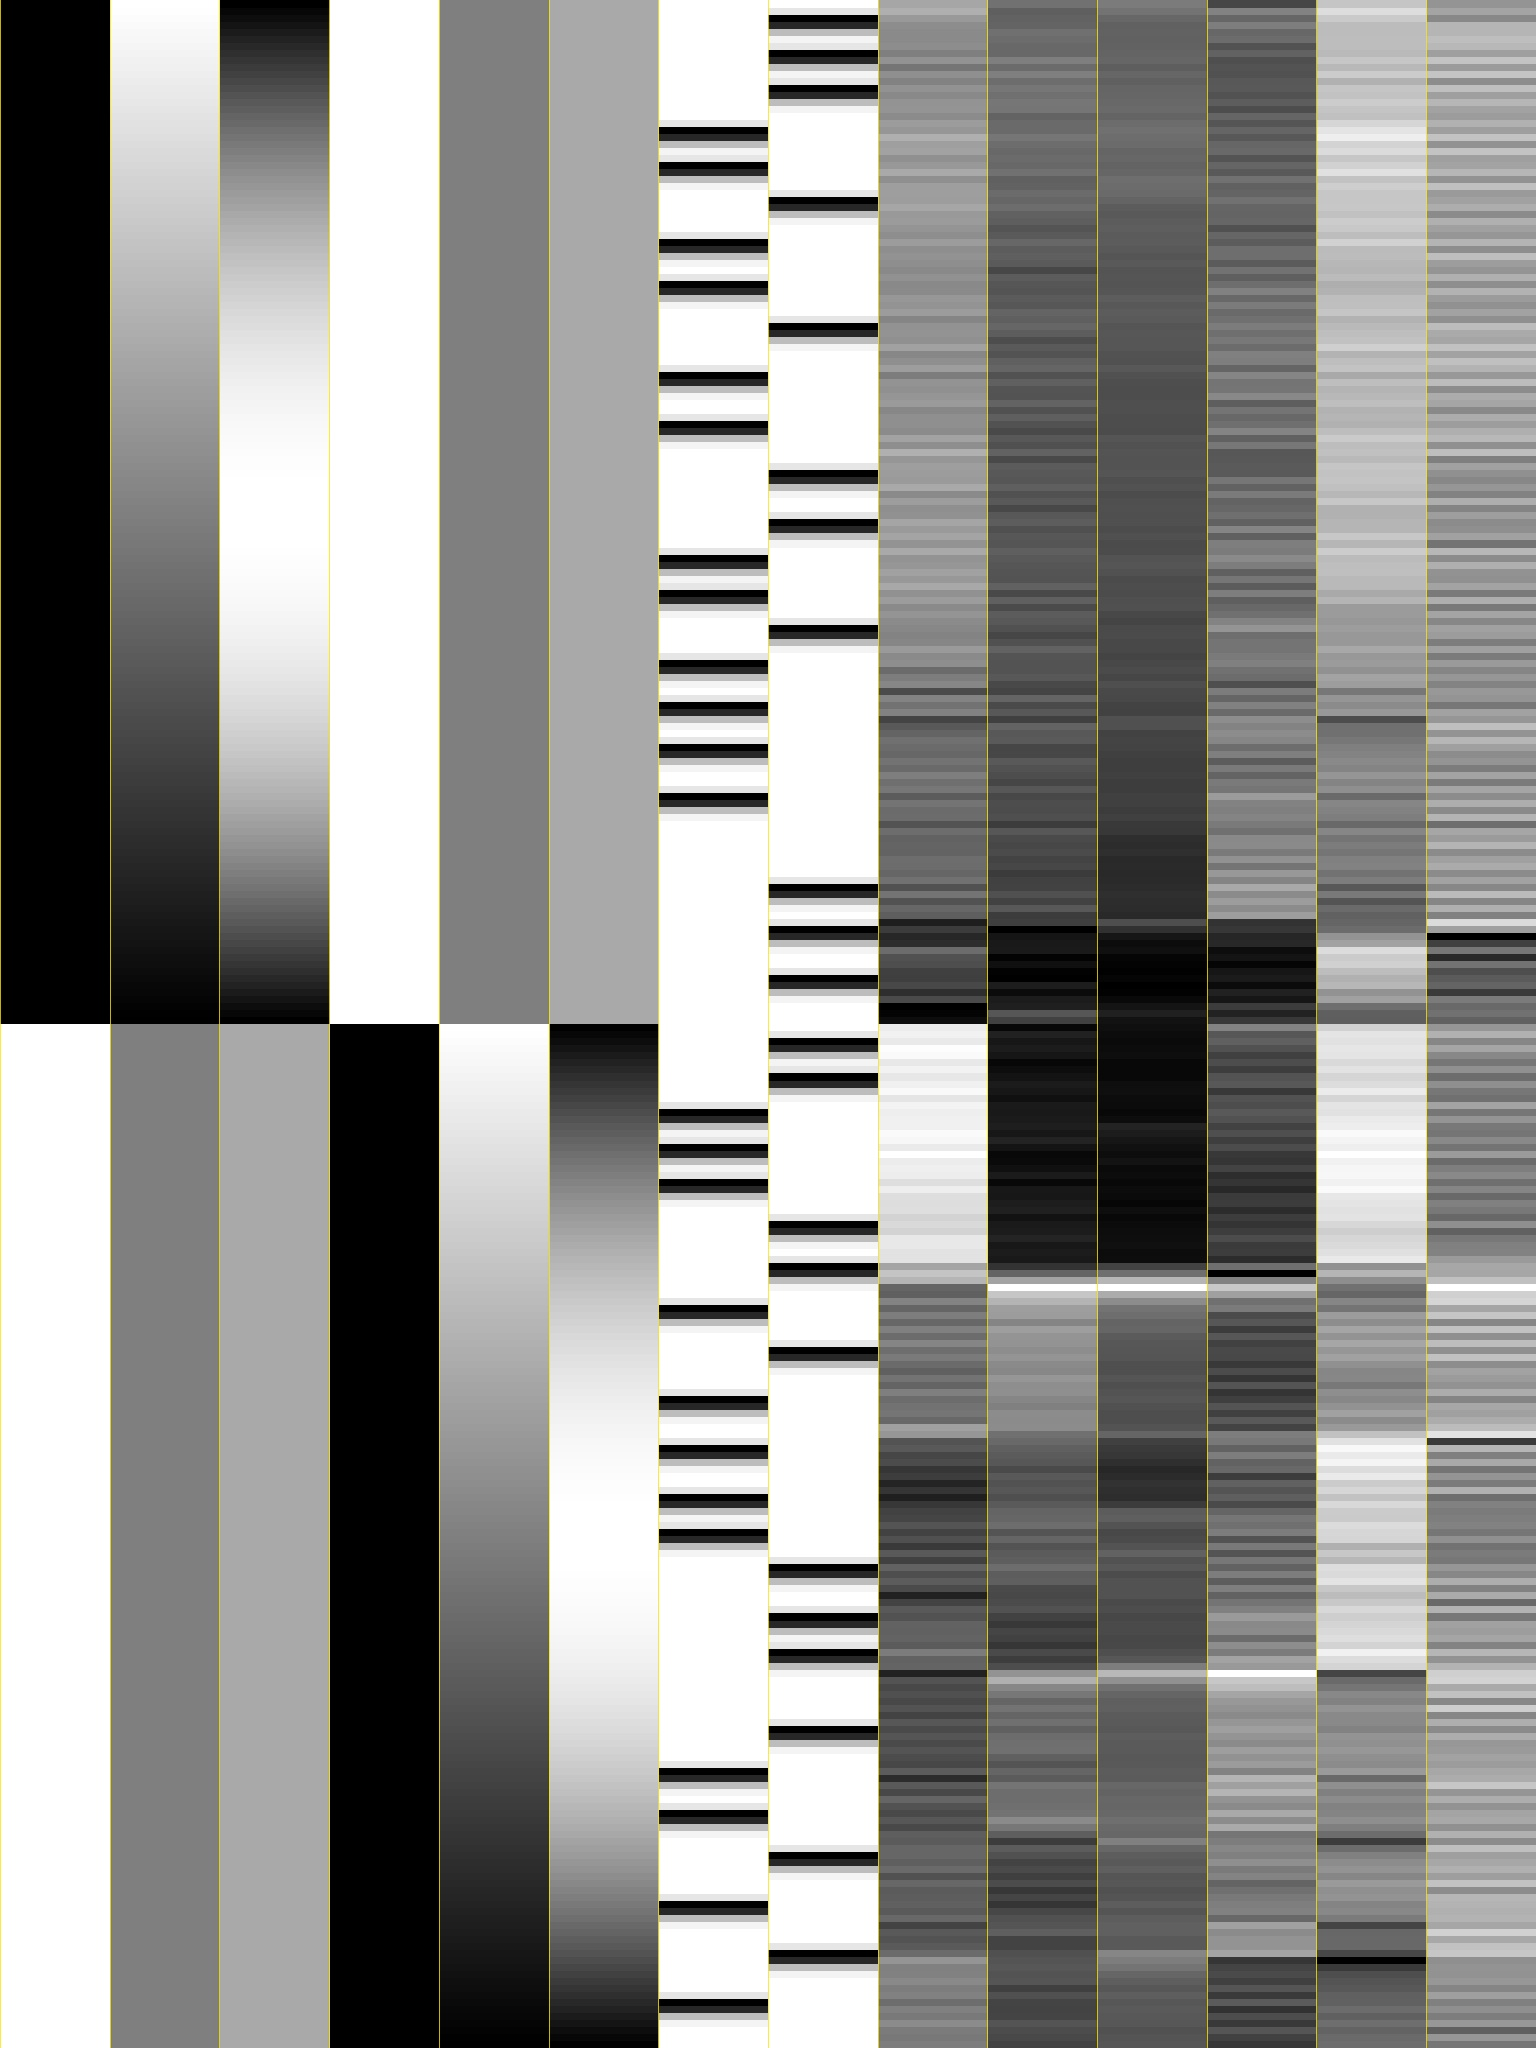

In [16]:
display(Image(filename='./afni_pro_glm/sub_08.results/X.jpg',  width=700))

To view the names of the individual regressors in the design matrix, you can run the following command. This will list the labels in the same order they appear in the matrix, helping you verify which columns correspond to drift terms, task conditions, and motion parameters.

In [17]:
!1d_tool.py -infile ./afni_pro_glm/sub_08.results/X.xmat.1D -show_labels

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
++ labels are: ['Run#1Pol#0', 'Run#1Pol#1', 'Run#1Pol#2', 'Run#2Pol#0', 'Run#2Pol#1', 'Run#2Pol#2', 'congruent#0', 'incongruent#0', 'mot_demean[0]#0', 'mot_demean[1]#0', 'mot_demean[2]#0', 'mot_demean[3]#0', 'mot_demean[4]#0', 'mot_demean[5]#0']


In addition to this, you’ll also see a visualization of the design matrix using the file ```X.xmat.1D``` below. This provides another way to examine the structure of the GLM model, showing when each regressor is active across the time series. Make sure the design matrix looks reasonable.

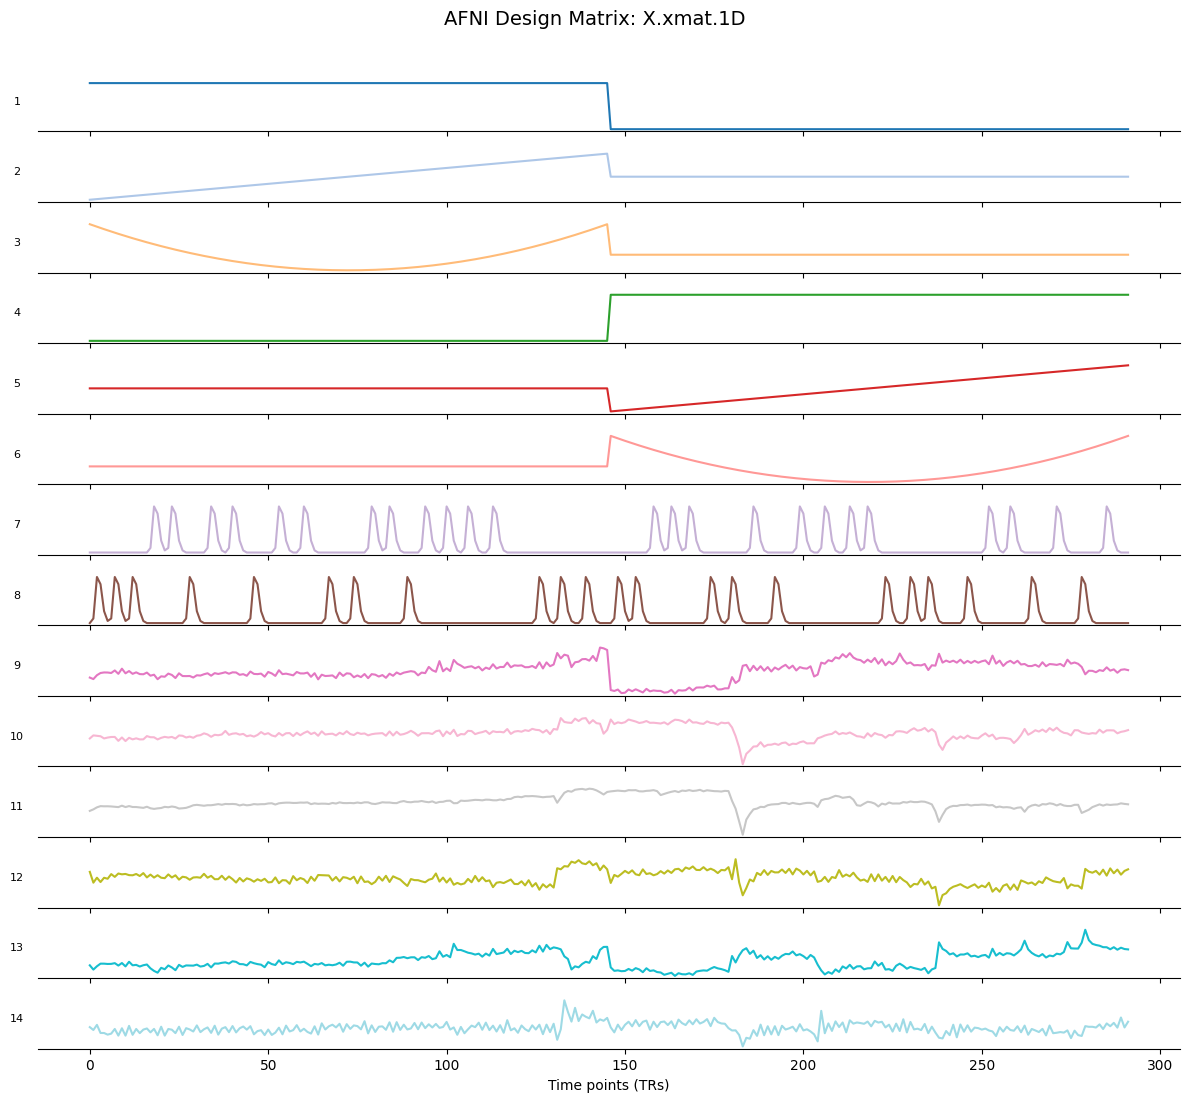

In [18]:
# Load the design matrix
xmat = np.loadtxt('./afni_pro_glm/sub_08.results/X.xmat.1D')

# Set up number of regressors and colors
n_regressors = xmat.shape[1]
colors = matplotlib.colormaps.get_cmap('tab20').resampled(n_regressors)

# Plot each regressor in its own row with a distinct color
fig, axes = plt.subplots(nrows=n_regressors, ncols=1, figsize=(12, n_regressors * 0.8), sharex=True)

for i in range(n_regressors):
    ax = axes[i]
    ax.plot(xmat[:, i], color=colors(i))
    ax.set_yticks([])
    ax.set_ylabel(f'{i+1}', rotation=0, fontsize=8, labelpad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

axes[-1].set_xlabel('Time points (TRs)', fontsize=10)
plt.suptitle('AFNI Design Matrix: X.xmat.1D', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Quality Check
AFNI automatically generates a quality control directory named ```QC_sub_08```, which contains images and summary metrics for each preprocessing and GLM step such as motion estimates, outlier fractions and EPI-to-anatomical alignment. These quality control plots are stored in the ```media/``` subfolder and can be displayed within the notebook to visually inspect the success of each step.

The ```show_qc_image()``` function can be used to display quality control images directly within the notebook. It takes the image filename and an optional title to present relevant QC plots inline.

In [19]:
def show_qc_image(filename, title=None):
    from IPython.display import Image, display
    if title:
        print(f'\n📊 {title}')
    display(Image(filename=filename))


📊 EPI to Anatomical Alignment


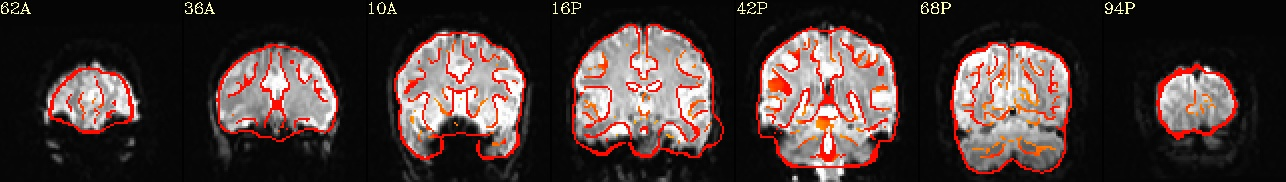

In [20]:
show_qc_image('./afni_pro_glm/sub_08.results/QC_sub_08/media/qc_01_ve2a_epi2anat.cor.jpg', 'EPI to Anatomical Alignment')



📊 Anatomical to MNI template Alignment


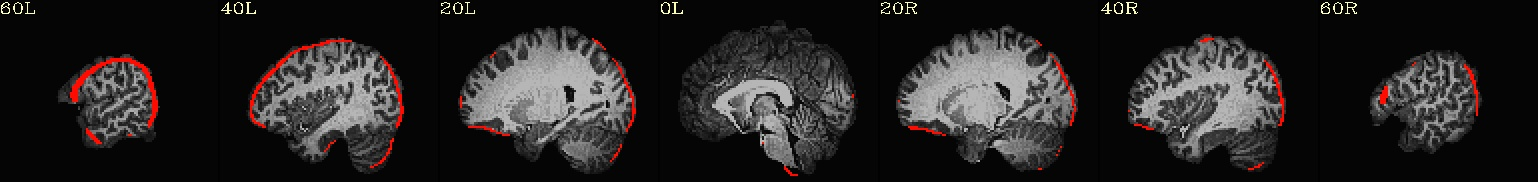

In [21]:
show_qc_image('./afni_pro_glm/sub_08.results/QC_sub_08/media/qc_02_va2t_anat2temp.sag.jpg', 'Anatomical to MNI template Alignment')


📊 Full F_stat (stats.sub_08_REML)


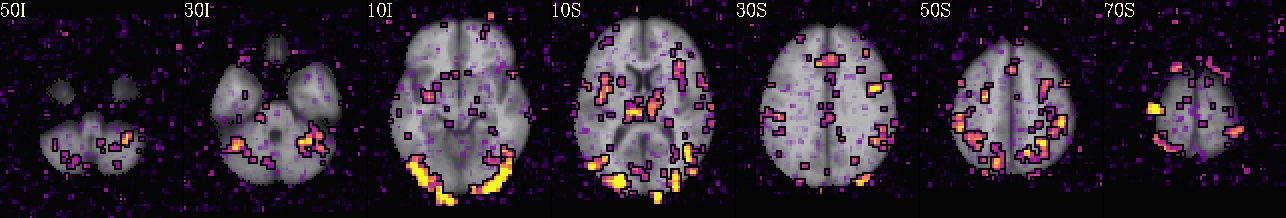

In [22]:
show_qc_image('./afni_pro_glm/sub_08.results/QC_sub_08/media/qc_03_vstat_Full_Fstat.axi.jpg', 'Full F_stat (stats.sub_08_REML)')

### Statistical Files
AFNI’s GUI provides extensive control over how to explore statistical maps. However, for this analysis, we will visualize some of these results using Nilearn to plot thresholded contrast maps. First, we'll convert the ```stats.sub_08_REML``` file to NIfTI format using ```AFNItoNIFTI``` and inspect the metadata of the stats.sub_08_REML dataset with the command ```3dinfo```.

In [23]:
!3dAFNItoNIFTI -prefix ./afni_pro_glm/sub_08.results/stats.sub_08_REML+tlrc.nii.gz ./afni_pro_glm/sub_08.results/stats.sub_08_REML+tlrc

++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]


In [24]:
!3dinfo -verb ./afni_pro_glm/sub_08.results/stats.sub_08+tlrc.HEAD

++ 3dinfo: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]

Dataset File:    stats.sub_08+tlrc
Identifier Code: XYZ_x4aAlweUZ-h-BasfMg8M3Q  Creation Date: Thu May  1 05:30:14 2025
Template Space:  MNI
Dataset Type:    Func-Bucket (-fbuc)
Byte Order:      LSB_FIRST [this CPU native = LSB_FIRST]
Storage Mode:    BRIK
Storage Space:   14,124,916 (14 million) bytes
Geometry String: "MATRIX(-3,0,0,90,0,-3,0,126,0,0,3,-72):61,73,61"
Data Axes Tilt:  Plumb
Data Axes Orientation:
  first  (x) = Left-to-Right
  second (y) = Posterior-to-Anterior
  third  (z) = Inferior-to-Superior   [-orient LPI]
R-to-L extent:   -90.000 [R] -to-    90.000 [L] -step-     3.000 mm [ 61 voxels]
A-to-P extent:   -90.000 [A] -to-   126.000 [P] -step-     3.000 mm [ 73 voxels]
I-to-S extent:   -72.000 [I] -to-   108.000 [S] -step-     3.000 mm [ 61 voxels]
Number of values stored at each pixel = 13
  -- At sub-brick #0 'Full_Fstat' datum type is float:            0 to       57.8599
     statcode = fift;  statpar = 

🧠 **Summary of Regressors and Contrasts**

The following table provides key information from the ```3dinfo``` output of the ```stats.sub_08_REML dataset```. It includes the regressors (conditions) and contrasts, as well as their associated T-statistics. These values will be visualized as T-stat maps using Nilearn to examine the statistical significance of the task-related effects.

| Sub-brick | Label                                      | Meaning                                                                 |
|-----------|--------------------------------------------|-------------------------------------------------------------------------|
| **#1**    | `congruent#0_Coef`                        | Beta weight (coefficient) for congruent trials                          |
| **#4**    | `incongruent#0_Coef`                      | Beta weight (coefficient) for incongruent trials                        |
| **#7**    | `incongruent-congruent_GLT#0_Coef`        | Beta weight (coefficient) for the contrast between incongruent and congruent trials |
| **#10**   | `congruent-incongruent_GLT#0_Coef`        | Beta weight (coefficient) for the contrast between congruent and incongruent trials |
| **#2**    | `congruent#0_Tstat`                       | T-statistic for congruent trials                                        |
| **#5**    | `incongruent#0_Tstat`                     | T-statistic for incongruent trials                                      |
| **#8**    | `incongruent-congruent_GLT#0_Tstat`       | T-statistic for incongruent > congruent                                 |
| **#11**   | `congruent-incongruent_GLT#0_Tstat`       | T-statistic for congruent > incongruent                                 |

Critical t-value for p=0.05 and df=278: 1.969


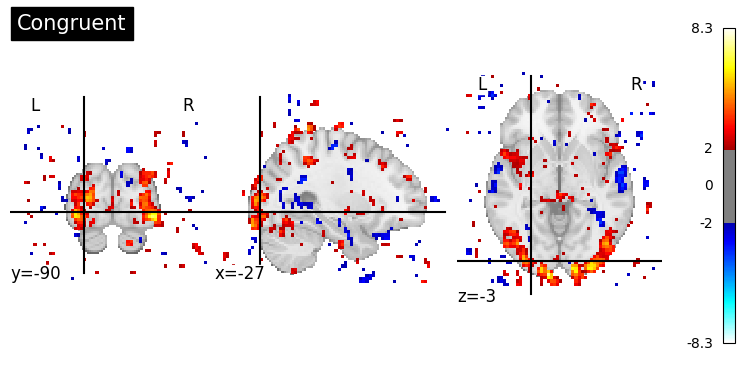

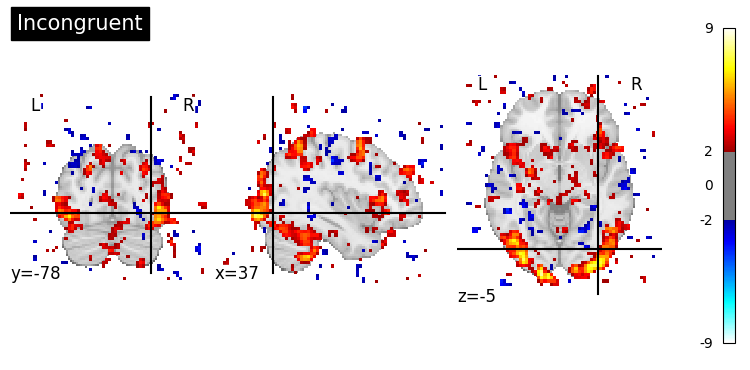

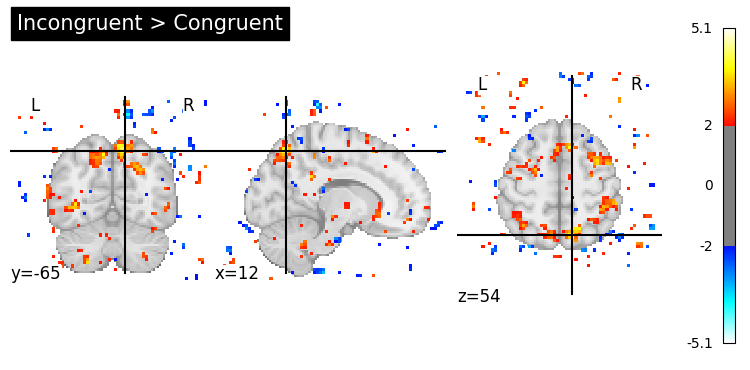

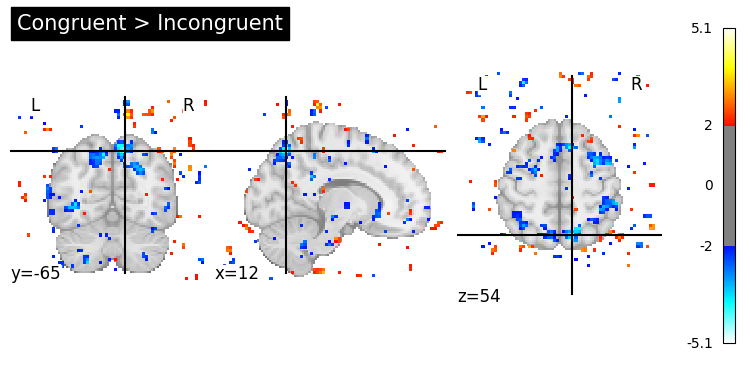

In [25]:
# Degrees of freedom (statpar)
df = 278

# Calculate the critical t-value for two-tailed p=0.05
alpha = 0.05
critical_t_value = t.ppf(1 - alpha/2, df)
print(f"Critical t-value for p=0.05 and df={df}: {np.round(critical_t_value,3)}")

# Load image
img = nib.load('./afni_pro_glm/sub_08.results/stats.sub_08_REML+tlrc.nii.gz')
data = img.get_fdata()
affine = img.affine

# Extract contrasts
tstat_congruent = data[:, :, :, 0, 2] #sub-brick #2
tstat_incongruent = data[:, :, :, 0, 5]
tstat_incongruent_gt_congruent = data[:, :, :, 0, 8]
tstat_congruent_gt_incongruent = data[:, :, :, 0, 11]

# Make NIfTI images
tstat_congruent_img = nib.Nifti1Image(tstat_congruent, affine)
tstat_incongruent_img = nib.Nifti1Image(tstat_incongruent, affine)
tstat_contrast1_img = nib.Nifti1Image(tstat_incongruent_gt_congruent, affine)
tstat_contrast2_img = nib.Nifti1Image(tstat_congruent_gt_incongruent, affine)

# Plot
plotting.plot_stat_map(tstat_congruent_img, title="Congruent", threshold=critical_t_value) 
plotting.plot_stat_map(tstat_incongruent_img, title="Incongruent", threshold=critical_t_value)
plotting.plot_stat_map(tstat_contrast1_img, title="Incongruent > Congruent", threshold=critical_t_value)
plotting.plot_stat_map(tstat_contrast2_img, title="Congruent > Incongruent", threshold=critical_t_value)

plotting.show()